In [1]:
import sys
import os
import numpy as np
import pandas as pd
import transformers
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime
ROOT = os.path.abspath('../')
sys.path.append(ROOT)
import models
from util import *

In [134]:
DATA_DIR = os.path.join(ROOT,'data')
MODEL_DIR = os.path.join(ROOT,'models')
LOG_DIR = os.path.join(ROOT,'logs')
CHECKPT_DIR = os.path.join(LOG_DIR,'checkpoints')
# MODEL = 'jplu/tf-xlm-roberta-base' 
MODEL = 'distilroberta-base' 
N_EPOCHS = 2
BATCH_SIZE = 32
tf.keras.backend.clear_session()

In [3]:
# load transformers
config = transformers.AutoConfig.from_pretrained(MODEL,output_hidden_states=True)
transformer_1 = transformers.TFAutoModel.from_pretrained(MODEL,config=config)
transformer_2 = transformers.TFAutoModel.from_pretrained(MODEL,config=config)
transformer_3 = transformers.TFAutoModel.from_pretrained(MODEL,config=config)

In [4]:
# compile models
model_func_1 = models.build_roberta_dense
model_1 = model_func_1(transformer_1, tf.keras.optimizers.Adam(1e-5), tf.keras.losses.BinaryCrossentropy(), tf.keras.metrics.BinaryAccuracy())

model_func_2 = models.build_roberta_concat_dense
model_2 = model_func_2(transformer_2,tf.keras.optimizers.Adam(1e-5), tf.keras.losses.BinaryCrossentropy(), tf.keras.metrics.BinaryAccuracy())

In [5]:
model_3 = models.roberta_dense(transformer_3)
model_3.compile(tf.keras.optimizers.Adam(1e-5), tf.keras.losses.BinaryCrossentropy(), tf.keras.metrics.BinaryAccuracy())

In [6]:
# load pretrained model weights
weights_dir_1 = CHECKPT_DIR + '\\distilroberta-base-build_roberta_dense\\20200520-172144' 
model_1.load_weights(weights_dir_1)

weights_dir_2 = CHECKPT_DIR + '\\distilroberta-base-build_roberta_concat_dense\\20200521-010940' 
model_2.load_weights(weights_dir_2)


In [7]:
weights_dir_3 = CHECKPT_DIR + '\\distilroberta-base-roberta_dense\\20200523-151605' 
model_3.load_weights(weights_dir_3)

In [91]:
# load and preprocess validation data
tokenizer = transformers.AutoTokenizer.from_pretrained(MODEL)
train_raw = pd.read_csv(os.path.join(DATA_DIR,'jigsaw-toxic-comment-train-processed-seqlen128.csv.zip'))
reduced_train = pd.concat([train_raw.query('toxic==0').sample(60000,random_state=1),
                           train_raw.query('toxic==1')]).sample(frac=1)
x_train = batch_encode(reduced_train.comment_text.values, tokenizer, max_len = models.MAX_LEN)
y_train = reduced_train.toxic.values

validation_raw = pd.read_csv(os.path.join(DATA_DIR,'validation.csv.zip'))
x_validate = batch_encode(validation_raw.comment_text.values,tokenizer, max_len = models.MAX_LEN)
y_validate = validation_raw.toxic.values

test_raw = pd.read_csv(os.path.join(DATA_DIR,'test.csv.zip'))


In [87]:
validation_raw.lang.unique()
validation_raw.lang.values.shape

(8000,)

In [93]:
test_raw.lang.unique()

array(['tr', 'ru', 'it', 'fr', 'pt', 'es'], dtype=object)

In [9]:
validate_dataset = (tf.data.Dataset.from_tensor_slices((x_validate,y_validate))
                    .batch(BATCH_SIZE)
                    .prefetch(-1))

In [10]:
# make predictions
model_1_pred = model_1.predict(validate_dataset)
model_2_pred = model_2.predict(validate_dataset)
model_3_pred = model_3.predict(validate_dataset)

In [11]:
# validate on validation dataset
auc_metric =  tf.keras.metrics.AUC(num_thresholds=200)
auc_metric.reset_states()
_ = auc_metric.update_state(y_validate,model_1_pred.squeeze())
model_1_auc = auc_metric.result().numpy()
auc_metric.reset_states()
_ = auc_metric.update_state(y_validate,model_2_pred.squeeze())
model_2_auc = auc_metric.result().numpy()
auc_metric.reset_states()
_ = auc_metric.update_state(y_validate,model_3_pred.squeeze())
model_3_auc = auc_metric.result().numpy()




accuracy_metric = tf.keras.metrics.BinaryAccuracy()
accuracy_metric.update_state(y_validate,model_1_pred.squeeze())
model_1_acc = accuracy_metric.result().numpy()
accuracy_metric.reset_states()
_ = accuracy_metric.update_state(y_validate,model_2_pred.squeeze())
model_2_acc = accuracy_metric.result().numpy()
accuracy_metric.reset_states()
_ = accuracy_metric.update_state(y_validate,model_3_pred.squeeze())
model_3_acc = accuracy_metric.result().numpy()

print(f"Model 1 AUC:{model_1_auc} | Model 2 AUC: {model_2_auc} | Model 3 AUC: {model_3_auc}")
print(f"Model 1 ACC:{model_1_acc} | Model 2 ACC: {model_2_acc} | Model 3 ACC: {model_3_acc}")


Model 1 AUC:0.6988505721092224 | Model 2 AUC: 0.6624488830566406 | Model 3 AUC: 0.6896920204162598
Model 1 ACC:0.846875011920929 | Model 2 ACC: 0.8478749990463257 | Model 3 ACC: 0.8466249704360962


In [30]:
xv = np.array(x_validate)
xv.shape
xv[0,None]

array([[    0,   381,  6526,   201,   257,  7718, 10265,   579,  9071,
        16432,   784,  4308,   102,  1076,   910, 12379,   263,  1437,
         1437,  1437,   259,  2359,  1437,  1437,   479,  7879,  4600,
          326, 13688,   263,  1943,  5272,  6821,  2677,   991,  2102,
         1177,   897, 43947, 12921,   102,  3840,  9695,  8685,   271,
         2628,  1076,  1916,  1423,  6505, 24969,    10,  5489,  3938,
        22734,  9697,  5679,  9488,   242,  2628, 36460,   118,  2727,
            4,  1437,  1437,  1437,  4058, 11387,  3104,   179,   820,
        38740,  1437,  1437, 11403,     6,  7398,   368,     6,  2084,
         7984,   625,     4,  1437,  1437,  1437,  1437,  1437,   601,
           35,  3818,   508,  4401,  2266,    36, 41934,    43,     2,
            1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,
      

In [52]:
inp = tf.keras.layers.Input(shape=(models.MAX_LEN,),dtype=tf.int32)
print(inp)
out = transformer_3(inp, training=False)[0][:,0,:]
emb_model = tf.keras.Model(inputs=inp, outputs=out)
emb_model.compile()
emb_model

Tensor("input_7:0", shape=(None, 128), dtype=int32)


In [55]:
rs = emb_model.predict(validate_dataset)


In [57]:
rs.shape

(8000, 768)

In [58]:
from sklearn import manifold
tsne = sklearn.manifold.TSNE(n_components=2, init='pca', random_state=1)
X_tsne = tsne.fit_transform(rs)

In [88]:
x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min)

tsne_data = np.concatenate((X_norm, y_validate[:,None],validation_raw.lang.values[:,None]),axis=-1)


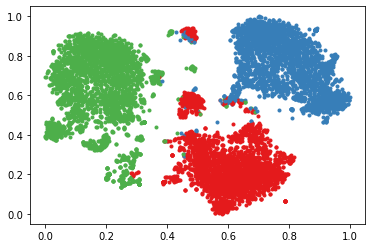

In [89]:
lang_dict = {'es':0,'it':1,'tr':2}
fig, ax = plt.subplots()

for i in tsne_data:
    ax.plot(i[0],i[1],'.',color=plt.cm.Set1(lang_dict[i[3]]))
plt.show()

In [105]:
w = model_3.dense_layer.weights
print(w[0].numpy().shape)
print(w[1].numpy().shape)

(768, 1)
(1,)


In [106]:
w[1]

<tf.Variable 'roberta_dense/dense_3/bias:0' shape=(1,) dtype=float32, numpy=array([-0.00055382], dtype=float32)>

In [107]:
dir(model_3.dense_layer)

['_TF_MODULE_IGNORED_PROPERTIES',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_activity_regularizer',
 '_add_inbound_node',
 '_add_trackable',
 '_add_variable_with_custom_getter',
 '_attribute_sentinel',
 '_auto_track_sub_layers',
 '_autocast',
 '_build_input_shape',
 '_call_accepts_kwargs',
 '_call_arg_was_passed',
 '_call_fn_args',
 '_call_full_argspec',
 '_callable_losses',
 '_checkpoint_dependencies',
 '_clear_losses',
 '_collect_input_masks',
 '_compute_dtype',
 '_dedup_weights',
 '_deferred_dependencies',
 '_dtype',
 '_dtype_defaulted_to_floatx',
 '_dtype_policy',
 '_dynamic',
 '_eager_add_metric',
 '_eager_loss

In [113]:
model_3.dense_layer

In [136]:
dense = tf.keras.layers.Dense(1,activation='sigmoid',weights=model_3.dense_layer.get_weights())

In [150]:
dense.build((768,))

In [154]:
dense.set_weights(model_3.dense_layer.get_weights())
dense.get_weights()[1]

array([-0.00055382], dtype=float32)

In [118]:
model_3.dense_layer.get_config()

{'name': 'dense_3',
 'trainable': True,
 'dtype': 'float32',
 'units': 1,
 'activation': 'sigmoid',
 'use_bias': True,
 'kernel_initializer': {'class_name': 'GlorotUniform',
  'config': {'seed': None}},
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'kernel_regularizer': None,
 'bias_regularizer': None,
 'activity_regularizer': None,
 'kernel_constraint': None,
 'bias_constraint': None}

In [ ]:
des